In [4]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [5]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# given by the assignment
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [7]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (3500, 28, 28)	Training tagets: (3500, 1)
Validation Data: (100, 28, 28)	Validation tagets: (100, 1)
Testing Data: (145, 28, 28)	Testing tagets:(145, 1)


In [8]:
def plot(image, target):
    plt.imshow(image, cmap="hot")
    plt.title('J' if target == 0 else 'C')
    # targets are binary encoded 0 == 'J' and 1 == 'C'
    plt.show()

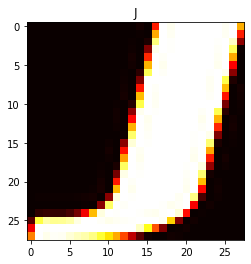

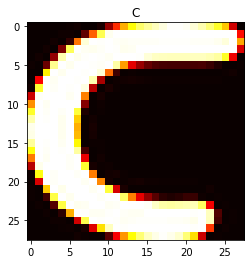

In [9]:
plot(trainData[0], trainTarget[0])
plot(trainData[1], trainTarget[1])

In [10]:
def augment(X, w, b):
    # flatten X
    if len(X.shape) == 3:
        X = X.reshape(X.shape[0], -1)
    # insert 1's at position 0 along the columns
    X = np.insert(X, 0, 1, axis=1)
    
    # insert b at the front of W
    w = np.insert(w, 0, b, axis=0)
    
    return X, w

In [11]:
def predict(w, b, X):
    X = X.reshape(X.shape[0], -1)
    return X.dot(w)

In [12]:
def accuracy(w, b, X, y):
    y = y.reshape(-1)
    y_pred = predict(w, b, X)
    y_pred = np.vectorize(lambda z: 1 if z > 0 else 0)(y_pred)
    return sum(y_pred == y) / y.shape[0]

# 1 Linear Regression
### 1. Loss Function and Gradient

In [13]:
# Mean Squared Error Loss
def MSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    return np.square(X.dot(w) + b - y).mean() + reg * np.square(w).sum()

def gradMSE(w, b, X, y, reg):
    X = X.reshape(X.shape[0], -1)
    y = y.reshape(-1)
    N = y.shape[0]
    
    w_grad = 2.0/N * X.T.dot(X.dot(w) + b - y) #+ reg * np.linalg.norm(w)
    b_grad = 2/N * np.sum(X.dot(w) + b - y)
    return w_grad, b_grad

"""
X = trainData
y = trainTarget
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)

gradMSE(w, b, X, y, 0.1)
"""


'\nX = trainData\ny = trainTarget\nN = X.shape[0]\nd = X.shape[1] * X.shape[2]\n\nw = np.random.random_sample(d)\nb = np.random.random_sample(1)\n\ngradMSE(w, b, X, y, 0.1)\n'

### 2. Gradient Descent Implementation

In [41]:
def grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol, validData=None, validTarget=None, testData=None, testTarget=None, printing=True):
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    test_loss, test_acc = [], []
    # printing = True # SANDRA
    for e in range(epochs):
        grad_w, grad_b = gradMSE(w, b, X, y, reg)
        w -= alpha * grad_w
        b -= alpha * grad_b
        
        # Calculating Statistics
        train_loss.append( MSE(w, b, X, y, reg) )
        train_acc.append( accuracy(w, b, X, y) )

        if not validData is None and not validTarget is None:
            valid_loss.append( MSE(w, b, validData, validTarget, reg) )
            valid_acc.append( accuracy(w, b, validData, validTarget) )
        if not testData is None and not testTarget is None:
            test_loss.append( MSE(w, b, testData, testTarget, reg) )
            test_acc.append( accuracy(w, b, testData, testTarget) )
        
        # Print Losses and Accurancies if printing is on
        if printing:
            print(f"Training loss: {train_loss[-1]:.4f}\tTraining acc: {train_acc[-1]*100:.2f}%")
            if not validData is None and not validTarget is None:
                print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
            if not testData is None and not testTarget is None:
                print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")

        # Check stopping condition
        if e > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
            break

    statistics = (train_loss, train_acc)
    if not validData is None and not validTarget is None:
        statistics += (valid_loss, valid_acc, )
    if not testData is None and not testTarget is None:
        statistics += (test_loss, test_acc,)
    # Python 3.8 made this easier, but 3.7 you have to do this
    out = (w, b, *statistics)
    
    return out

X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]

w = np.random.random_sample(d)
b = np.random.random_sample(1)
w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, 0.001, 10, 0, 0.01)
#train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
train_loss, train_acc = statistics
print(train_acc)
print(statistics)

Training loss: 12549.3361	Training acc: 50.20%
Training loss: 6667.6867	Training acc: 50.20%
Training loss: 3573.0045	Training acc: 50.20%
Training loss: 1943.4489	Training acc: 50.20%
Training loss: 1084.2289	Training acc: 50.20%
Training loss: 630.1329	Training acc: 49.37%
Training loss: 389.1785	Training acc: 44.23%
Training loss: 260.4358	Training acc: 38.43%
Training loss: 190.8349	Training acc: 36.80%
Training loss: 152.4636	Training acc: 36.97%
[0.502, 0.502, 0.502, 0.502, 0.502, 0.4937142857142857, 0.4422857142857143, 0.3842857142857143, 0.368, 0.3697142857142857]
[[12549.33606427262, 6667.6866837189855, 3573.004456924381, 1943.4488550028398, 1084.2289274268544, 630.1328854156873, 389.17847024969296, 260.43578452623484, 190.8348749748555, 152.46357307597216], [0.502, 0.502, 0.502, 0.502, 0.502, 0.4937142857142857, 0.4422857142857143, 0.3842857142857143, 0.368, 0.3697142857142857]]


### 3. Tuning the Learning Rate

In [107]:
# functions to plot loss and accuracy
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    if title == None:
        ax.set_title("Loss")
    else:
        ax.set_title(title)
    
    ax.set_xlabel("Epochs")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    if title == None:
        ax.set_title("Accuracy")
    else:
        ax.set_title(title)

    ax.set_xlabel("Epochs")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")

In [21]:
# Test your implementation of Gradient Descent with 5000 epochs and \lambda = 0. Investigate the
# impact of learning rate, \alpha = 0.005, 0.001, 0.0001 on the performance of your classifier. 
# Plot the training, validation and test losses.

# Eric

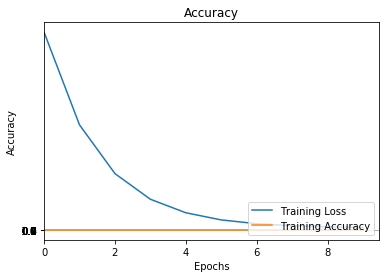

In [22]:
# plot_loss(np.arange(0, len(train_loss), 1), train_loss)#, valid_loss, test_loss)
# plot_accuracy(np.arange(0, len(train_loss), 1), train_acc)#, valid_acc, test_acc)

### 4. Generalization

lambda = 0.001
Training loss: 47.8083	Training acc: 50.11%
Validation loss: 61.7821	Validation acc: 45.00%
Testing loss: 50.0953	Testing acc: 53.79%


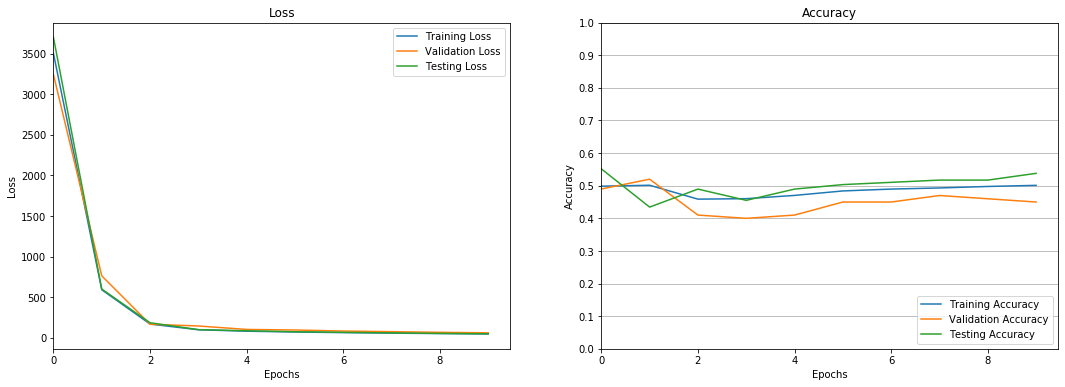

lambda = 0.1
Training loss: 54.3468	Training acc: 52.46%
Validation loss: 71.6176	Validation acc: 50.00%
Testing loss: 54.2122	Testing acc: 57.24%


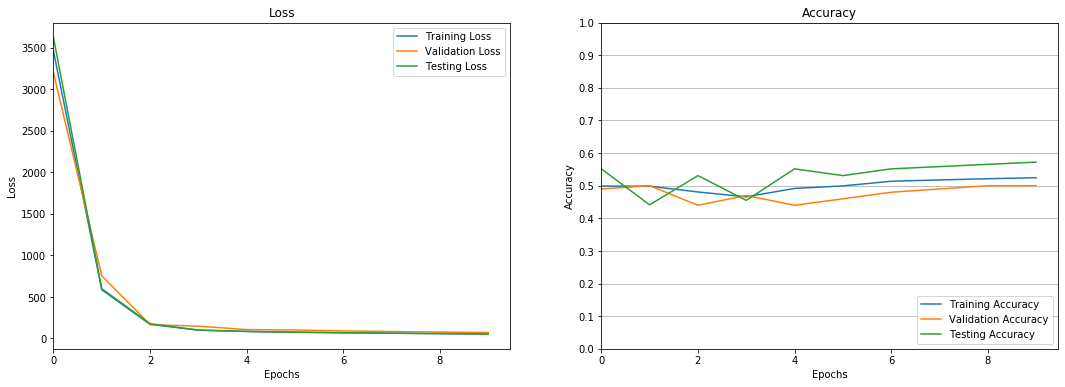

lambda = 0.5
Training loss: 79.2213	Training acc: 54.26%
Validation loss: 89.4981	Validation acc: 53.00%
Testing loss: 81.6135	Testing acc: 59.31%


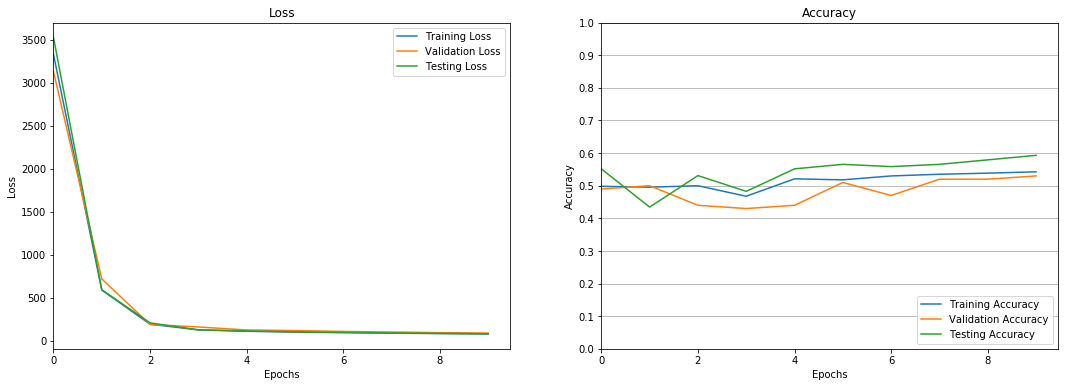

In [55]:
# 4. Generalization
# Investigate impact by modifying the regularization parameter, \lambda = {0.001, 0.1, 0.5}. 
# Plot the training, validation and test loss for \alpha = 0:005 and report the final training, 
# validation and test accuracy of your classifier.
# SANDRA

# restate variables
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
X = trainData
N = X.shape[0]
d = X.shape[1] * X.shape[2]
alpha = 0.005
epochs = 10
error_tol = 0.01

for reg in [0.001, 0.1, 0.5]:
    
    print("lambda =", reg)
    
    w = np.random.random_sample(d)
    b = np.random.random_sample(1)

    w, b, *statistics = grad_descent_MSE(w, b, trainData, trainTarget, alpha, epochs, reg, error_tol, validData, validTarget, testData, testTarget, printing=False)
    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = statistics
    
    print(f"Training loss: {train_loss[-1]:.4f}{'':.20s}\tTraining acc: {train_acc[-1]*100:.2f}%")
    print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1]*100:.2f}%")
    print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1]*100:.2f}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

### 5. Comparing Batch GD with normal equation

In [46]:
def least_squares(X, y):
    N = X.shape[0]
    d = X.shape[1] * X.shape[2]
    X, _ = augment(X, np.zeros(X.shape[0]), 0)
    y = y.reshape(-1)
    
    # overparameterized (deep learning)
    if N < d:
        w_aug = X.T.dot(np.linalg.inv( np.dot(X, X.T) )).dot(y)
    # underparameterized (typical case)
    else:
        w_aug = np.linalg.inv( X.T @ X ) @ X.T @ y
    
    return w_aug[1:], w_aug[0]
        
# compare above to gradient descent solution
w_LS, b_LS = least_squares(trainData, trainTarget)

# 2 Logistic Regression
## 2.1 Binary cross-entropy loss
### 1. Loss Function and Gradient

In [101]:
# this will work for both scalar and vector z
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Cross Entropy Loss
def crossEntropyLoss(w, b, X, y, reg):    
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    return 1.0/N * (-y.dot(np.log(y_hat+1e-20)) - (1 - y).dot(np.log(1 - y_hat+1e-20))) + reg/2.0 * np.square(w[1:]).sum()
    
    

def gradCE(w, b, X, y, reg):
    X, w = augment(X, w, b)
    y = y.reshape(-1)
    N = y.shape[0]
    
    y_hat = sigmoid(X.dot(w))
    
    w_grad = 1.0 /N * X.T.dot(y_hat - y) + reg * w
    
    return w_grad[1:], w_grad[0] - reg * w[0]



### 2. Learning

In [102]:
def grad_descent(w, b, X, y, alpha, epochs, reg, error_tol, lossType="MSE", validData=None, validTarget=None,
                 testData=None, testTarget=None, printing=True):
    if lossType == "MSE":
        return grad_descent_MSE(w, b, X, y, alpha, epochs, reg, error_tol, printing=False)
    elif lossType == "CE":
        train_loss, train_acc = [], []
        valid_loss, valid_acc = [], []
        test_loss, test_acc = [], []
    # printing = True # SANDRA
        for i in range(epochs):
            grad_w, grad_b = gradCE(w, b, X, y, reg)
            w -= alpha * grad_w
            b -= alpha * grad_b

            # Calculating Statistics
            train_loss.append(crossEntropyLoss(w, b, X, y, reg))
            train_acc.append(accuracy(w, b, X, y))

            if validData is not None and validTarget is not None:
                valid_loss.append(crossEntropyLoss(w, b, validData, validTarget, reg))
                valid_acc.append(accuracy(w, b, validData, validTarget))
            if testData is not None and testTarget is not None:
                test_loss.append(crossEntropyLoss(w, b, testData, testTarget, reg))
                valid_acc.append(accuracy(w, b, testData, testTarget))

            # Print Losses and Accurancies if printing is on
            if printing:
                print(f"Training loss: {train_loss[-1]:.4f}\tTraining acc: {train_acc[-1] * 100:.2f}%")
                if validData is not None and validTarget is not None:
                    print(f"Validation loss: {valid_loss[-1]:.4f}\tValidation acc: {valid_acc[-1] * 100:.2f}%")
                if testData is not None and testTarget is not None:
                    print(f"Testing loss: {test_loss[-1]:.4f}\tTesting acc: {test_acc[-1] * 100:.2f}%")

            # Check stopping condition
            if i > 1 and np.abs(train_loss[-2] - train_loss[-1]) <= error_tol:
                break

        statistics = (train_loss, train_acc)
        # if validData is not None and validTarget is not None: # SANDRA
        #     statistics += (valid_loss, valid_acc,)
        # if testData is not None and testTarget is not None:
        #     statistics += (test_loss, test_acc,)
        out = (w, b, *statistics)

        return out

    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

### 3. Comparision to Linear Regression

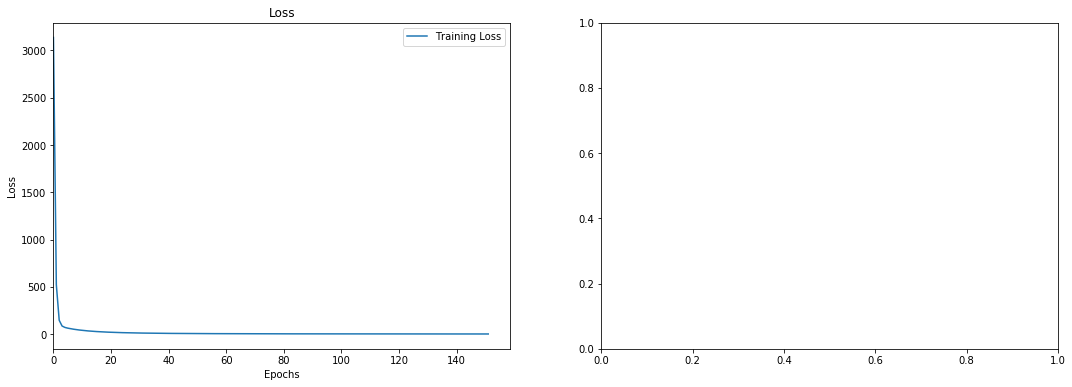

In [108]:
# For zero weight decay, learning rate of 0.005 and 5000 epochs, 
# plot the training cross entropy loss and MSE loss for 
# logistic regression and linear regression respectively.
# Comment on the effect of cross-entropy loss convergence behaviour.

# restate variables
# trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
# X = trainData
# N = X.shape[0]
# d = X.shape[1] * X.shape[2]
alpha = 0.005 # learning rate
epochs = 5000
reg = 0 # weight decay
error_tol = 0.01

w = np.random.random_sample(d)
b = np.random.random_sample(1)
# Linear regression
w_lin, b_lin, *statistics_lin = grad_descent(w, b, trainData, trainTarget, alpha, epochs, reg, error_tol, printing=False, lossType="MSE")
lin_train_loss, lin_train_acc = statistics_lin

# Logistic regression
w_log, b_log, *statistics_log = grad_descent(w, b, trainData, trainTarget, alpha, epochs, reg, error_tol, printing=False, lossType="CE")
log_train_loss, log_train_acc = statistics_log

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plot_loss(np.arange(0, len(lin_train_loss), 1), lin_train_loss, ax=ax[0])
# plot_loss(np.arange(0, len(lin_train_loss), 1), lin_train_loss, log_train_loss, ax=ax[0])
plt.show()
plt.close()

# 3 Batch Gradient Descent vs. SGD and Adam
## 3.1 SGD
### 1. Building the Computational Graph

In [0]:
def buildGraph(loss="MSE"):
    #Initialize weight and bias tensors
    tf.set_random_seed(421)

    if loss == "MSE":
        # Your implementation
        pass
    elif loss == "CE":
        #Your implementation here
        pass
    else:
        raise ValueError("Variable 'lossType' must be either 'MSE' or 'CE'.")

### 2. Implementing Stochastic Gradient Descent

In [ ]:
# Implement the SGD algorithm for a minibatch size of 500 
# optimizing over 700 epochs 2, minimizing the MSE (you will repeat this for the CE later).
# Calculate the total number of batches required by dividing the number
# of training instances by the minibatch size. After each epoch you will need to reshuffle the
# training data and start sampling from the beginning again. Initially, set \lambda = 0 and continue
# to use the same \alpha value (i.e. 0.001). After each epoch, store the training, validation and test
# losses and accuracies. Use these to plot the loss and accuracy curves.

### 3. Batch Size Investigation

### 4. Hyperparameter Investigation

### 5. Cross Entropy Loss Investigation

### 6. Comparison against Batch GD